In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/local_Documents/TheoryAndPracticeOfCausalInference`


In [2]:
Pkg.add(["CSV", "DataFrames", "HTTP", "Statistics"])
using CSV, DataFrames, HTTP, Statistics

    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `~/local_Documents/TheoryAndPracticeOfCausalInference/Project.toml`
  No Changes to `~/local_Documents/TheoryAndPracticeOfCausalInference/Manifest.toml`


In [3]:
data03 = CSV.read(HTTP.get("https://raw.githubusercontent.com/mtakahashi123/causality/main/data03.csv").body, DataFrame; missingstring = "NA");

In [4]:
function attach(x::DataFrame)
    for i in propertynames(x)
        @eval $(i) = $(x).$(i)
    end
end

attach (generic function with 1 method)

## STUVA

Stable Unit Treatment Value Assumption

さとゔぁと発音するらしい。ずっとすとぅーばだと思ってた。

処置を受ける個体ごとに処置の値が安定

- 相互干渉がない
- 個体に対する隠れた処置がない

二番目の仮定がやや難しそう。

本質的に除外制約 = 別の処置による因果効果の存在を除外するための仮定。

## 識別性の条件

**識別性(identifiability)** = データからパラメタを一意に推定できること。

識別性＝正値性（$0<P(T=1)<1$, 両端を含まない）＋独立性(${Y(1), Y(0) | T}$, 割り付けについての独立性)

特に，独立性は無作為割付けならば用意に満たされるが，観察研究では必ずしもそうでないので注意が必要。


## 実験研究におけるATEの推定

テストの例の割り付け（補習を受けるかどうか）は無作為ではなかったため，独立性の仮定が満たされない＝ATEのナイーブな推定量にバイアスが入る。

補習の有無の割り付けは入試の成績（x1）に依存している。また，入試の成績は（数学力という潜在変数を共通の親に持つ形で）期末試験の成績（＝潜在的結果変数）に依存している。

## 共変量の役割

無交絡性(unconfoundedness) = ある変数（の組）$\mathbf{X}$を条件付ければ，独立性の仮定が成り立つ。

$$
\{Y_i(1), Y_i(0)\} \perp\!\!\!\!\perp T_i|\it{X}
$$

合わせて条件付き正値性も重要。

$$
0 < P(T=1|\it{X}) < 1
$$

強い意味での無視可能な割り付け (stringly ignorable treatment assignment)＝STUVAと無交絡性，条件付き正値性が成り立つ。



In [5]:
data03

,x1,y3,t1,y0t,y1t
,Int64,Int64,Int64,Int64,Int64
1,70,74,1,62,74
2,70,63,0,63,74
3,70,73,1,62,73
4,70,71,1,65,71
5,70,74,1,63,74
6,75,67,0,67,77
7,75,77,1,68,77
8,75,68,0,68,76
9,75,77,1,68,77


- x1 入学試験成績
- y3 期末試験成績
- t1 処置
- y1t 潜在的結果変数（期末試験成績の）

y1tは処置が1のものについてはy3と同じ値が入る。

上から5人ごとに割り付け確率が変わっており，上の集団から順に4/5, 3/5, 2/5, 1/5となっている。

In [6]:
for g in 1:4
    i = (g - 1) * 5 + 1
    p = mean(data03.t1[i:i+4])
    println("処置群$(g)の割り付け確率は$(100p)%")
end

処置群1の割り付け確率は80.0%
処置群2の割り付け確率は60.0%
処置群3の割り付け確率は40.0%
処置群4の割り付け確率は20.0%


In [7]:
describe(data03)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Int64,Float64,Int64,Int64,DataType
1,x1,80.0,70,80.0,90,0,Int64
2,y3,77.25,63,77.0,91,0,Int64
3,t1,0.5,0,0.5,1,0,Int64
4,y0t,72.2,62,71.0,82,0,Int64
5,y1t,82.0,71,81.5,92,0,Int64


In [8]:
attach(data03)

In [9]:
mean(y3[@. t1 == 1]) - mean(y3[@. t1 == 0])

3.3000000000000114

In [10]:
mean(y1t) - mean(y0t)

9.799999999999997

## 回帰分析と共分散分析

無視可能な割り付けの場合でのATEの推定方法

In [11]:
Pkg.add(["StatsPlots", "GLM"])

   Resolving package versions...
  No Changes to `~/local_Documents/TheoryAndPracticeOfCausalInference/Project.toml`
  No Changes to `~/local_Documents/TheoryAndPracticeOfCausalInference/Manifest.toml`


In [12]:
using StatsPlots, GLM
gr(fontfamily = "IPAGothic")

Plots.GRBackend()

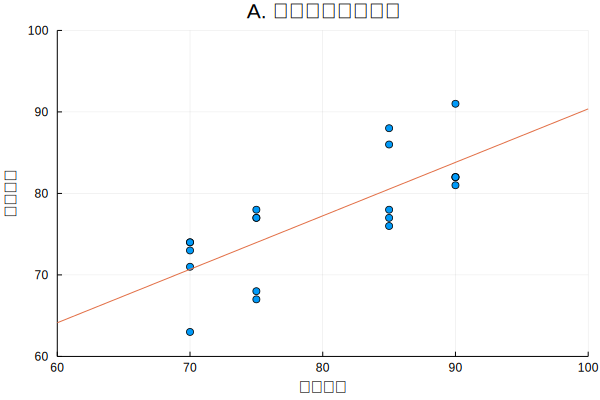

In [13]:
p1 = @df data03 scatter(:x1, :y3, xaxis = "入学試験", yaxis = "期末試験", title = "A. 散布図（全集団）", label = "", ylims = (60, 100), xlims = (60, 100))
ols_fit = glm(@formula(y3 ~ x1), data03, Normal(), IdentityLink()) # Gaussian family and identidy link function.
plot!(p1, 60:1:100, predict(ols_fit, DataFrame(x1 = 60:100)), seriestype = :line, label = "")

In [14]:
glm(@formula(y3 ~ x1), data03, Normal(), IdentityLink()) # 回帰分析の例

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Normal{Float64}, IdentityLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y3 ~ 1 + x1

Coefficients:
─────────────────────────────────────────────────────────────────────
              Coef.  Std. Error     z  Pr(>|z|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────
(Intercept)  24.77    10.7163    2.31    0.0208   3.76635   45.7737
x1            0.656    0.133305  4.92    <1e-06   0.394727   0.917273
─────────────────────────────────────────────────────────────────────

In [15]:
glm(@formula(y3 ~ t1), data03, Normal(), IdentityLink()) # ANOVA, 分散分析の例

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Normal{Float64}, IdentityLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y3 ~ 1 + t1

Coefficients:
─────────────────────────────────────────────────────────────────────
             Coef.  Std. Error      z  Pr(>|z|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────
(Intercept)   75.6     2.21523  34.13    <1e-99   71.2582    79.9418
t1             3.3     3.1328    1.05    0.2922   -2.84018    9.44018
─────────────────────────────────────────────────────────────────────

In [16]:
ancova_fit = glm(@formula(y3 ~ x1 + t1), data03, Normal(), IdentityLink()) # ANCOVA, 共分散分析の例

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Normal{Float64}, IdentityLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y3 ~ 1 + x1 + t1

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      z  Pr(>|z|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  -2.12562     2.27423   -0.93    0.3500  -6.58302    2.33178
x1            0.930846    0.027042  34.42    <1e-99   0.877844   0.983847
t1            9.81592     0.427572  22.96    <1e-99   8.97789   10.6539
─────────────────────────────────────────────────────────────────────────

信頼区間（confint）はJuliaの計算結果のほうがやや小さめに推定されている様子。原因は不明。

In [17]:
coef_ancova = coef(ancova_fit)
b0 = coef_ancova[1]
b1 = coef_ancova[2]
b2 = coef_ancova[3];

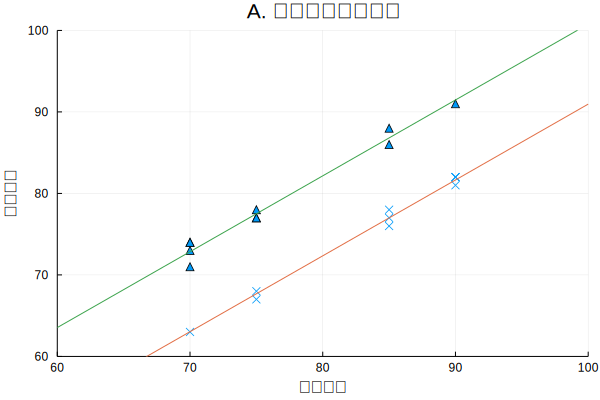

In [18]:
p2 = @df transform(data03, :t1 => ByRow(x -> x == 0 ? :xcross : :utriangle) => :t1) scatter(:x1, :y3, markershape = :t1, xaxis = "入学試験", yaxis = "期末試験", title = "A. 散布図（群ごと）", label = "", xlims = (60, 100), ylims = (60, 100))
plot!(p2, x -> b0 + b1 * x, label = "")
plot!(p2, x -> b0 + b2 + b1 * x, label = "")
p2